##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Interest rate tools in TFF

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Cashflows_Rate_Curves.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/tf-quant-finance/blob/master/tf_quant_finance/examples/jupyter_notebooks/Cashflows_Rate_Curves.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [0]:
#@title Install TF Quant Finance
!pip install tf-quant-finance

### This notebook demonstrates the use of the TFF toolbox for performing common tasks related to interest rates. This includes computing the present values of cashflows for a collection of bonds, and for building and interpolating from rate curves, with an emphasis on:

  * **Batching**: Tensorflow is vectorized out of the box. Tensorflow Finance (TFF) written to leverage this wherever possible. We illustrate the advantage of batching for computing forward rates.

In [0]:
#@title Imports { display-mode: "form" }
import datetime
from dateutil.relativedelta import relativedelta
import holidays
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import seaborn as sns
import tensorflow as tf
import time

 # TFF for Tensorflow Finance
import tf_quant_finance as tff 
from tf_quant_finance import rates

from IPython.core.pylabtools import figsize
figsize(21, 14) # better graph size for Colab  

import warnings
warnings.filterwarnings("ignore",
                        category=FutureWarning)  # suppress printing warnings


# Business Day Convention
The pricing in Example 1 uses the *modified following business day convention* for the US for treasure payment dates. That is, if the coupon date falls on a weekend or holiday, it is paid on the following business day, unless said following business day falls into the next calendar month, in which case we go backwards to the nearest previous business day. It also provides functionality to generate regular coupon payments, before applying business day convention.  

In [0]:
#@title Implement Business Day Convention
def get_coupon_dates(current_date, maturity_date, months = 6):
  # Compute sequence of dates `months` apart starting at maturity_date,
  # working backwards to last one after current_date. 
  cashflow_dates = []
  date = maturity_date
  while date >= current_date:
    cashflow_dates.append(date)
    date = date + relativedelta(months=-months)
  # Check if dates are on a US holiday or weekend
  return pd.to_datetime(cashflow_dates).sort_values()
 
def get_modified_following_date(dates):
  # Get the modified folliwng business day for the US. 
  BDayUS = CustomBusinessDay(calendar=USFederalHolidayCalendar(), n = 1)       
  def is_weekday(dates):
    # Identify weekend days
    return ~dates.weekday_name.isin(['Saturday', 'Sunday'])

  def in_next_month(dates1, dates2): 
    return dates1.month == dates2.month - 1

  def next_bus_day(dates):
    # If next business day in a new month shift to previous business day
    fwd = dates + BDayUS
    return fwd.where(~in_next_month(dates, fwd), dates - BDayUS)

  def payment_day(dates):
    return dates.where(is_weekday(dates), next_bus_day(dates))
  return payment_day(dates)


## Example 1: **Cashflows in TFF**: Computing present values for a portfolio of bonds.

 ### Coupon Bond Valuation
Calculating the value of a coupon bond factors in the present value of annual or semi-annual coupon payments and the face value of the bond.

The present value of expected cash flows is added to the present value (PV) of the face value of the bond as seen in the following formula:

$$
\begin{align}
PV(Bond) &= PV(Coupons) + PV(FaceValue) \\
&= \sum_t \frac{C_t}{(1+i)^t} + \frac{F}{(1+i)^T}\\
\end{align}
$$
Where \\
$C_t$ are future coupon payments

$i$ is the yield to maturity (or internal rate of return, IRR) of the bond. 

$F$ is the face value of the bond.

$t$ is times at which the corresponding coupon payments occur.

$T$ is the time to maturity of the bond.


# Example Data (US Treasury Bonds)
The example below shows how to price a selection of US Treasury Bonds
Source: https://www.wsj.com/market-data/bonds (Close of market on 20/09/2019)

The data represent six US Treasuries:  
*   2-Year Note (Coupon: 1.5%, Maturity: 30/09/2021)
*   3-Year Note (Coupon: 1.5%, Maturity: 15/09/2022)
*   5-Year Note (Coupon: 1.5%, Maturity: 30/09/2024)
*   7-Year Note (Coupon: 1.625%, Maturity: 30/09/2026)
*   10-Year Note (Coupon: 1.625%, Maturity: 15/08/2029)
*   30-Year Bond (Coupon: 2.25%, Maturity: 15/08/2049)

We use Modified Following day count convention (i.e. move to the next business day, 
unless it falls in a different month, in which case use the previous business day),
and the US holidays in the Python `holidays` module.

In [0]:
#@title Pricing US Treasury Bonds
dtype = np.float64
exp_dates = ['"2021-09-30"', '"2022-09-15"', '"2024-09-30"', '"2026-09-30"', 
             '"2029-08-15"', '"2049-08-15"']
us_bond_data = {
    'present_date': [datetime.datetime.strptime('2019-09-20', '%Y-%m-%d').date()] * 6,
    'expiry_date': [datetime.datetime.strptime(date, '"%Y-%m-%d"').date() for date in exp_dates], 
    'bond_type': ['2yr_note', '3yr_note', '5yr_note', '7yr_note', '10yr_note', 
                  '30yr_bond'],
    'face_value': [100, 100, 100, 100, 100, 1000],
    'coupon_rate': [0.015, 0.015, 0.015, 0.01625, 0.01625, 0.02250],
    'coupon_frequency': [0.5] * 6
}

us_bond_data = pd.DataFrame.from_dict(us_bond_data)

# Generate times of cashflows (using modified following business day convention)
# for US federal holidays. 
payment_dates = list(map(get_coupon_dates, us_bond_data.present_date,
                        us_bond_data.expiry_date))
number_of_coupons = list(map(len, payment_dates)) # get number of coupons per bond
payment_dates = np.concatenate(payment_dates, axis = 0)
payment_dates_modified = get_modified_following_date(
    pd.to_datetime(payment_dates))
current_date = pd.Series(pd.to_datetime(us_bond_data.present_date[0])).repeat(len(payment_dates_modified))
payment_times_days = (payment_dates_modified.values - current_date)
times = payment_times_days.apply(lambda x: float(x.days) / 365) # Days to years


# Generate actual cashflows.
coupon_payments = (us_bond_data.face_value * us_bond_data.coupon_rate * 
                   us_bond_data.coupon_frequency)
coupon_cashflows = np.repeat(coupon_payments, number_of_coupons)
redemption_cashflows = np.zeros(np.sum(number_of_coupons))
redemption_indexes = np.cumsum(number_of_coupons) - 1
redemption_cashflows[redemption_indexes] = us_bond_data.face_value
cashflows = np.array(coupon_cashflows + redemption_cashflows, dtype = dtype)
# Compute groups for bond cashflows. 
groups = np.repeat(range(0, us_bond_data.shape[0]), number_of_coupons)

# Bond Yield Curve 
# Yields ontained from https://www.wsj.com/market-data/bonds (as on 20/09/2019)
tenor_curve = [2, 3, 5, 10, 30]
rate_curve = [0.017419, 0.016885, 0.016614, 0.017849, 0.02321]
days_to_maturity = (us_bond_data.expiry_date - us_bond_data.present_date)  
years_to_maturity = list(days_to_maturity.apply(lambda x: float(x.days) / 365))


# Linear Interpolation of curve get yields to maturity.
rate_curve_interpolated = tff.math.interpolation.linear.interpolate(
    years_to_maturity, tenor_curve, 
    rate_curve, dtype = np.float64)
with tf.Session() as sess:
  rate_curve_interpolated = sess.run(rate_curve_interpolated)

# Create Tensorflow Graph using pv_from_yields in rates.
present_values = rates.cashflows.pv_from_yields(cashflows, times, 
                                                rate_curve_interpolated,
                                                groups) 

with tf.Session() as sess:
  present_values = sess.run(present_values)

us_bond_data['present_value'] = present_values

print("Priced US Treasury Bonds:")
print('\n')
us_bond_data

Priced US Treasury Bonds:




,present_date,expiry_date,bond_type,face_value,coupon_rate,coupon_frequency,present_value
0,2019-09-20,2021-09-30,2yr_note,100,0.01500,0.5,100.212446
1,2019-09-20,2022-09-15,3yr_note,100,0.01500,0.5,99.446898
2,2019-09-20,2024-09-30,5yr_note,100,0.01500,0.5,99.887903
3,2019-09-20,2026-09-30,7yr_note,100,0.01625,0.5,100.139738
4,2019-09-20,2029-08-15,10yr_note,100,0.01625,0.5,98.648447
5,2019-09-20,2049-08-15,30yr_bond,1000,0.02250,0.5,984.092036


### Generating large bond portfolio 
To demonstrate scale we simulate a mix of bonds (of total number_of_bonds) with face values between min_face_value and max_face_value (in increments of 100), paying either semi-annual or annual coupons, with coupon rates of 2%, 4%, 6%, 8%, and 10%. We use the yield curve we used above for US treasury bonds. 

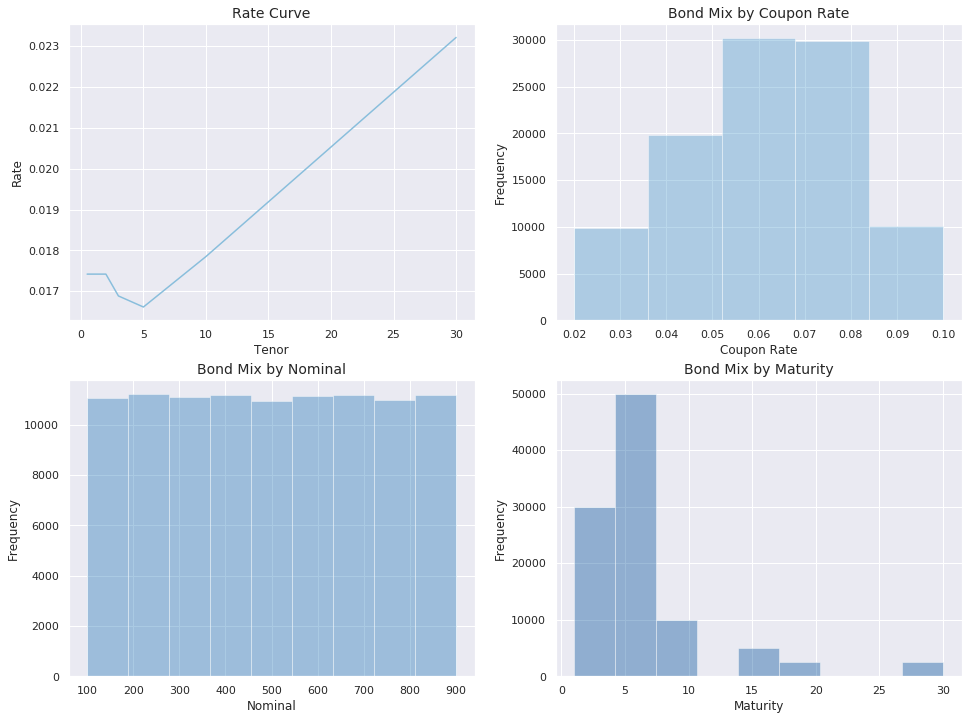

In [0]:
#@title Create Bond Data
number_of_bonds = 100000 #@param
min_face_value = 100 
max_face_value = 1000
# Face values for bonds
bond_face_values = range(min_face_value,
                         max_face_value, 100)
coupon_frequencies = [0.5, 1]
coupon_rates = [0.02, 0.04, 0.06, 0.08, 0.10]

# Range of bond maturities.
bond_maturities = [1, 2, 3, 5, 7, 10, 15, 20, 30]

# Create a mix of 100,000 bonds.
large_bond_data = {
    'face_value': np.random.choice(bond_face_values, number_of_bonds),
    'coupon_frequency': np.random.choice(coupon_frequencies, number_of_bonds),
    'coupon_rate': np.random.choice(coupon_rates, number_of_bonds, 
                                    p=[0.1, 0.2, 0.3, 0.3, 0.1]),
    'maturity': np.random.choice(bond_maturities, number_of_bonds,
                                 p=[0.1, 0.1, 0.1, 0.2, 0.3, 0.1, 0.05, 
                                    0.025, 0.025])
    }

large_bond_data = pd.DataFrame.from_dict(large_bond_data)

# Rate curve interpolation
curve_required_tenors2 = np.arange(0.5, 30.5, 0.5)

rate_curve_interpolated2 = tff.math.interpolation.linear.interpolate(
    curve_required_tenors2, tenor_curve, 
    rate_curve, dtype = np.float64)
with tf.Session() as sess:
  rate_curve_interpolated2 = sess.run(rate_curve_interpolated2)


# Plot distribution of bonds by face value, coupon rate, and yield.
plt.figure(figsize=(16,12))
col_palette = sns.color_palette("Blues")
plt.subplot(2, 2, 1)
# Plot Rate Curve
sns.set()
sns.lineplot(curve_required_tenors2, rate_curve_interpolated2,
             color=col_palette[2])
plt.title('Rate Curve', fontsize=14)
plt.xlabel('Tenor', fontsize=12)
plt.ylabel('Rate', fontsize=12)

# Coupon rate distribution
plt.subplot(2, 2, 2)
sns.set()
sns.distplot(large_bond_data['coupon_rate'], kde=False,
             color = col_palette[3], bins=5)
plt.title('Bond Mix by Coupon Rate', fontsize=14)
plt.xlabel('Coupon Rate', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Nominal value distribution
plt.subplot(2, 2, 3)
sns.set()
sns.distplot(large_bond_data['face_value'], kde=False,
             color = col_palette[4], bins=9)
plt.title('Bond Mix by Nominal', fontsize=14)
plt.xlabel('Nominal', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Nominal value distribution
plt.subplot(2, 2, 4)
sns.set()
sns.distplot(large_bond_data['maturity'], kde=False,
             color = col_palette[5], bins=9)
plt.title('Bond Mix by Maturity', fontsize=14)
plt.xlabel('Maturity', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

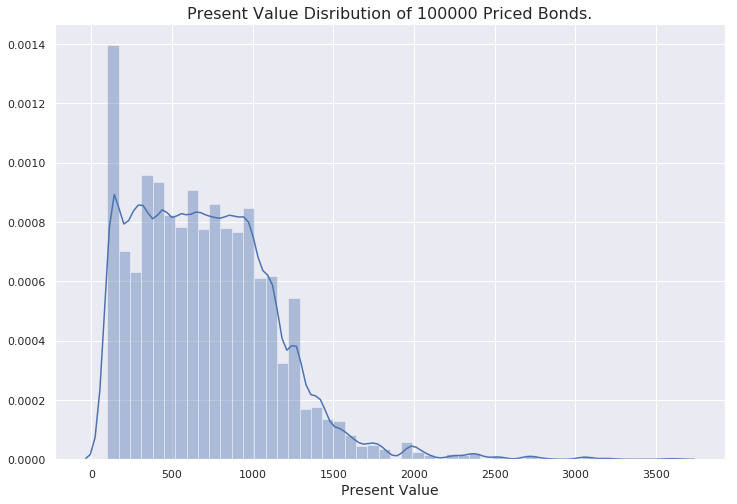

In [0]:
#@title Compute the present value for portfolio of bonds
dtype = np.float64
tf.reset_default_graph()

rate_curve_df = pd.DataFrame.from_dict({
    'tenor': curve_required_tenors2,
    'rate': rate_curve_interpolated2
})

# Create inputs (cashflows, times, groups) for `pv_from_yields`
large_number_of_coupons = large_bond_data.maturity / large_bond_data.coupon_frequency
large_number_of_coupons = large_number_of_coupons.astype(int)
large_coupon_payments = (large_bond_data.face_value * large_bond_data.coupon_rate * 
                         large_bond_data.coupon_frequency)
large_coupon_cashflows = np.repeat(large_coupon_payments, large_number_of_coupons)
large_redemption_cashflows = np.zeros(np.sum(large_number_of_coupons))
large_redemption_indexes = np.cumsum(large_number_of_coupons) - 1
large_redemption_cashflows[large_redemption_indexes] = large_bond_data.face_value
large_cashflows = np.array(large_coupon_cashflows + 
                           large_redemption_cashflows, dtype = dtype)

# The times of the cashflows.
large_times = list(map(np.arange, large_bond_data.coupon_frequency,
             large_bond_data.maturity + large_bond_data.coupon_frequency,
             large_bond_data.coupon_frequency))
large_times = np.concatenate(large_times, axis = 0)
large_groups = np.repeat(range(0, large_bond_data.shape[0]), 
                         large_number_of_coupons)

# Create Tensorflow Graph using pv_from_yields in rates.
present_values = rates.cashflows.pv_from_yields(large_cashflows, large_times, 
                                                rate_curve_interpolated2, 
                                                groups = large_groups)
with tf.Session() as sess:
  present_values = sess.run(present_values)

  # Plot distribution of present values of portfolio of bonds.
plt.figure(figsize=(12,8))
sns.set_context("talk")
col_palette = sns.color_palette("Blues")
sns.set()
ax = sns.distplot(present_values, kde=True)
plot_label = "Present Value Disribution of {} Priced Bonds.".format(number_of_bonds)
plt.title(plot_label, fontsize=16)
plt.xlabel('Present Value', fontsize=14)
plt.show()

## Example 2: Compute forward rates given a set of zero rates

Denote the price of a zero coupon bond maturing at time $t$ by $Z(t)$. Then the zero rate to time $t$ is defined as
$$
\begin{equation*}
    r(t) = - ln(Z(t)) / t
\end{equation*}
$$

This is the (continuously compounded) interest rate that applies between time $0$ and time $t$ as seen at time $0$. The forward rate between times $t1$ and $t2$ is defined as the interest rate that applies to the period $[t1, t2]$ as seen from today. Let $f(t1, t2) = -ln\frac{Z(t2)}{Z(t1)}$, then it followes that
$$\begin{align}
    \\
    exp(-f(t1, t2)(t2-t1)) &= Z(t2) / Z(t1)   \\
    f(t1, t2) &= - (ln Z(t2) - ln Z(t1)) / (t2 - t1) \\
    f(t1, t2) &= (t2 * r(t2) - t1 * r(t1)) / (t2 - t1) \\\\
\end{align}$$
Given a sequence of increasing times $[t1, t2, ... tn]$ and the zero rates for those times, this function computes the forward rates that apply to the consecutive time intervals i.e. $[0, t1], [t1, t2], ... [t_{n-1}, tn]$ using the last equation above. Note that for the interval $[0, t1]$ the forward rate is the same as the zero rate.

### Generating zero rates data
We generate `num_zero_rates_bonds` sets of zero rates data with between 3 and 8 coupon payments at time points $[0.25, 0.5, 1, 1.5,2, 3, 5, 10]$, always starting at $0.25$ and then at subsequent time points, depending on the number of marked tenors. We generate zero rates as follows:


1.   Randomly draw a rate in $[0,0.15]$ for the first tenor
2.   Generate the rates for the subsequent tenors by incrementing the rate at the first tenor by a random draw from $[0, 0.02]$.

In [0]:
#@title Create Bond Data
num_zero_rate_bonds = 100000 #@param
num_tenors = [2, 3, 4, 5, 6, 7, 8, 10]
marked_tenors = [0.25, 0.5, 1, 1.5, 2, 3, 5, 10, 20, 30]

# Create a mix of `num_zero_rate_bonds` bonds.
set_num_tenors = np.random.choice(num_tenors, num_zero_rate_bonds)

def get_slice(n):
  return marked_tenors[slice(n)]

times = np.concatenate(list(map(get_slice, set_num_tenors)), axis = 0)
# Set up a grouping argument for implementing batching. See
# `forward_rates_from_yields` in tff.forwards.
groups = np.repeat(range(0, num_zero_rate_bonds), set_num_tenors)

# Construct Rate Curve to generate Zero Rates 
tf.reset_default_graph()
curve_required_tenors3 = marked_tenors
rate_curve_interpolated3 = tff.math.interpolation.linear.interpolate(
    curve_required_tenors3, tenor_curve, 
    rate_curve, dtype = np.float64)

with tf.Session() as sess:
  rate_curve_interpolated3 = sess.run(rate_curve_interpolated3)
  
def get_rates(n):
  # Perturb rate curve
    rates = rate_curve_interpolated3[0:n]
    rates =  rates + np.random.uniform(-0.0005, 0.0005, n)
    return rates
  
rates = np.concatenate(list(map(get_rates, set_num_tenors)), axis = 0)

zero_rate_data = {
    'times': times,
    'groups': groups,
    'rates': rates
    }

zero_rate_data_df = pd.DataFrame.from_dict(zero_rate_data)

wall time (with batching):  0.4285850524902344


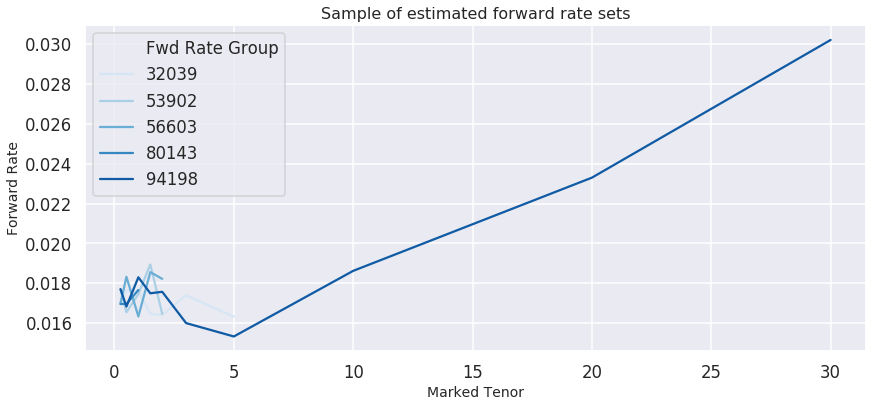

In [0]:
#@title Compute forward rates for sets with different number of tenors of zero rates with batching.
import tf_quant_finance.rates.forwards as forwards
dtype = np.float64
tf.reset_default_graph()

forward_rates = forwards.forward_rates_from_yields(
    rates, times, groups=groups, dtype=dtype)
t = time.time()
with tf.Session() as sess:
  forward_rates = sess.run(forward_rates)
time_batch = time.time() - t
zero_rate_data_df['forward_rates'] = forward_rates

# Plot forward rates for a random sample sets of zero rates
sample_groups = np.random.choice(np.unique(groups), 5)
plt.figure(figsize=(14,6))
col_palette = sns.color_palette("Blues", 5)
mask = list(zero_rate_data_df.groups.isin(sample_groups))
plot_data = zero_rate_data_df.iloc[mask]
sns.set()
sns.set_context("talk")
sns.lineplot(x='times', y='forward_rates', data=plot_data, 
             hue='groups',legend='full', palette=col_palette)

plt.title('Sample of estimated forward rate sets', fontsize=16)
plt.xlabel('Marked Tenor', fontsize=14)
plt.ylabel('Forward Rate', fontsize=14)
legend = plt.legend()
legend.texts[0].set_text("Fwd Rate Group")
plt.show()


### Forward rates (batching vs non-batching)
Below we compare the computation of forward rates with and without batching. We see that computing the forward rates for 100 bonds is about 2.5 times slower than computing the forward rates for 100000 bonds with batching.

In [0]:
#@title Compare forward rate computation: batching vs non-batching.
num_zero_rate_bonds2 = 100
num_tenors = [2, 3, 4, 5, 6, 7, 8, 10]
marked_tenors = [0.25, 0.5, 1, 1.5, 2, 3, 5, 10, 20, 30]

# Create a mix of 100,000 bonds.
set_num_tenors = np.random.choice(num_tenors, num_zero_rate_bonds2)

def get_slice(n):
  # Function to get marked tenors for a bond with 'n' tenors. 
  return marked_tenors[slice(n)]

times = np.concatenate(list(map(get_slice, set_num_tenors)), axis = 0)
# Set up a grouping argument for implementing batching. See
# `forward_rates_from_yields` in tff.forwards.
groups = np.repeat(range(0, num_zero_rate_bonds2), set_num_tenors)

# Construct Rate Curve to generate Zero Rates 
tf.reset_default_graph()
curve_required_tenors3 = marked_tenors
rate_curve_interpolated3 = tff.math.interpolation.linear.interpolate(
    curve_required_tenors3, tenor_curve, 
    rate_curve, dtype = np.float64)

with tf.Session() as sess:
  rate_curve_interpolated3 = sess.run(rate_curve_interpolated3)
  
def get_rates(n):
  # Perturb rate curve
    rates = rate_curve_interpolated3[0:n]
    rates =  rates + np.random.uniform(-0.0005, 0.0005, n)
    return rates
  
rates = np.concatenate(list(map(get_rates, set_num_tenors)), axis = 0)

# Non-batch.
tf.reset_default_graph()
time_non_batch = 0
with tf.Session() as sess:
  for group in np.unique(groups):
    forward_rates_non_batch = forwards.forward_rates_from_yields(
        rates[groups == group], times[groups == group], dtype=dtype)
    t = time.time() 
    forward_rates_non_batch = sess.run(forward_rates_non_batch)
    time_non_batch += time.time() - t
print('wall time to price {} options without batching: '.format(num_zero_rate_bonds2), time_non_batch)
print('wall time to price {} options with batching: '.format(num_zero_rate_bonds), time_batch)
output_string = """Pricing {} bonds without batching is {} times slower than 
  pricing {} bonds with batching."""

print(output_string.format(num_zero_rate_bonds2, 
                           round(time_non_batch/time_batch, 1), 
                           num_zero_rate_bonds))

wall time (non-batch):  4.39509391784668
Pricing 100 bonds without batching is 10.3 times slower than 
  pricing 100000 bonds with batching.


### Pricing 100 bonds without batching is about 10 times slower than pricing 100000 bonds with batching.

## Example 3: Constructing a bond discount curve

Building discount curves is a core problem in mathematical finance. Discount curves are built using the available market data in liquidly traded rates
products. These include bonds, swaps, forward rate agreements (FRAs) or eurodollar futures contracts. 

Here we show how to build a bond discount rate curve. A discount curve is a function of time which gives the interest rate that applies to a unit of currency deposited today for a period of  time $t$. The traded price of bonds implicitly contains the market view on the discount rates. The purpose of discount curve construction is to extract this information. 

The algorithm we use here here is based on the Monotone Convex Interpolation method described by Hagan and West (2006, 2008).


In [0]:
# @title Create bond data
# The following example demonstrates the usage by building the implied curve
# from four coupon bearing bonds.

dtype=np.float64
# These need to be sorted by expiry time.
cashflow_times = [
                  np.array([0.25, 0.5, 0.75, 1.0], dtype=dtype),
                  np.array([0.5, 1.0, 1.5, 2.0], dtype=dtype),
                  np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0], dtype=dtype),
                  np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0], 
                           dtype=dtype)
                  ]
cashflows = [
    # 1 year bond with 5% three monthly coupon.
    np.array([12.5, 12.5, 12.5, 1012.5], dtype=dtype),
    # 2 year bond with 6% semi-annual coupon.
    np.array([30, 30, 30, 1030], dtype=dtype),
    # 3 year bond with 8% semi-annual coupon.
    np.array([40, 40, 40, 40, 40, 1040], dtype=dtype),
    # 4 year bond with 3% semi-annual coupon.
    np.array([15, 15, 15, 15, 15, 15, 15, 1015], dtype=dtype)
]
# The present values of the above cashflows.
pvs = np.array([
                999.68155223943393, 1022.322872470043, 1093.9894418810143,
                934.20885689015677
], dtype=dtype)

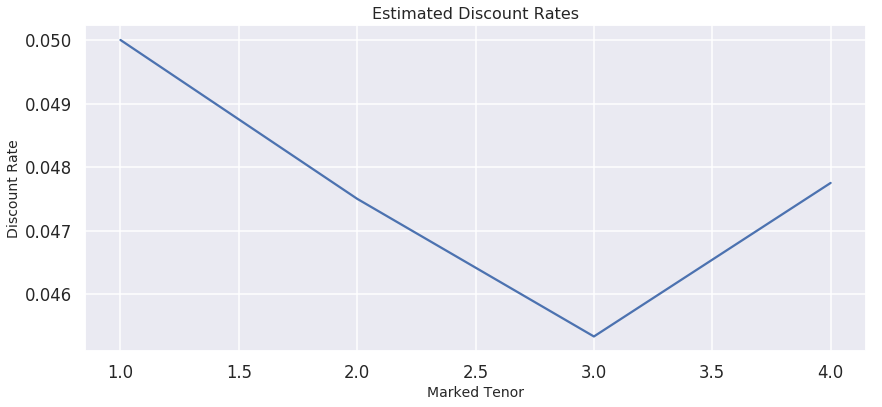

In [0]:
#@title Build and plot the bond curve 
tf.reset_default_graph()
from tf_quant_finance.rates import hagan_west

results = hagan_west.bond_curve(cashflows, cashflow_times, pvs)

with tf.Session() as sess:
  results = sess.run(results)

# Plot Rate Curve
plt.figure(figsize=(14,6))
col_palette = sns.color_palette("Blues", 2)
sns.set()
sns.set_context("talk")
sns.lineplot(x=results.times, y=results.discount_rates, palette=col_palette)
plt.title('Estimated Discount Rates', fontsize=16)
plt.xlabel('Marked Tenor', fontsize=14)
plt.ylabel('Discount Rate', fontsize=14)
plt.show()